In [3]:
import pickle
import os
import pandas as pd
import numpy as np
import sqlite3

from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader, TensorDataset

from src.models import *
from src.utils import *
from main import  load_dataset, backprop

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def normalize3(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return ((a - min_a) / (max_a - min_a + 0.0001)), min_a, max_a

def denormalize3(a_norm, min_a, max_a):
    return a_norm * (max_a - min_a + 0.0001) + min_a

def convert_to_windows(data, model):
    windows = []
    w_size = model.n_window
    for i, g in enumerate(data):
        if i >= w_size:
            w = data[i - w_size:i]  # cut
        else:
            w = torch.cat([data[0].repeat(w_size - i, 1), data[0:i]])  # pad
        windows.append(w if 'DTAAD' in model.name or 'Attention' in model.name or 'TranAD' in model.name else w.view(-1))
    return torch.stack(windows)

def load_model(modelname, dims):
    import src.models
    model_class = getattr(src.models, modelname)
    model = model_class(dims).double()
    fname = f'checkpoints/{modelname}_{args.dataset}/model.ckpt'
    if os.path.exists(fname) and (not args.retrain or args.test):
        checkpoint = torch.load(fname, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
        assert True
    return model

def filter_noise_es(df, alpha=0.4, reduction=False):
    import copy
    new_df = copy.deepcopy(df)
    
    for column in df:
        new_df[column] = df[column].ewm(alpha=alpha, adjust=False).mean()
    
    if reduction:
        return new_df[::len(df)]  # Adjust sparsity if needed
    else:
        return new_df

def wgn_pandas(df_withtime, snr, alpha=0.15, window_size=120):
    df_no_timestamp = df_withtime.drop(columns=['TimeStamp'])
    noisy_df = pd.DataFrame(index=df_no_timestamp.index, columns=df_no_timestamp.columns)

    for start in range(0, len(df_no_timestamp), window_size):
        window = df_no_timestamp.iloc[start:start + window_size]
        
        min_window, max_window = window.min(), window.max()
        #x = (window - min_window) / (max_window - min_window + 1e-4)
        Ps = np.sum(np.power(window, 2), axis=0) / len(window)
        Pn = Ps / (np.power(10, snr / 10))

        noise = np.random.randn(*window.shape) * np.sqrt(Pn.values)
        noisy_window = window + (noise / 100)

        noisy_df.iloc[start:start + window_size] = noisy_window
    
    noisy_df.reset_index(drop=True, inplace=True)
    noisy_df = filter_noise_es(pd.DataFrame(noisy_df, columns=noisy_df.columns), alpha)

    df_timestamp = df_withtime['TimeStamp']
    df_timestamp.reset_index(drop=True, inplace=True)

    df_withtime = pd.concat([df_timestamp, noisy_df], axis=1)
    return df_withtime

def percentage2severity(value):
    return (
        1 if 0 <= value < 5 else
        2 if 5 <= value < 20 else
        3 if 20 <= value < 40 else
        4 if 40 <= value < 75 else
        5 if 75 <= value <= 100 else
        6
    )

def preprocessPD_loadData(df_sel):
    df_sel = wgn_pandas(df_sel, 30, alpha=0.15)

    df_timestamp = df_sel.iloc[:, 0]
    df_feature =  df_sel.iloc[:, 1:]
    df_feature = df_feature[feature_set]
    raw_active = df_feature['Active Power'].values

    df_feature, _, _ = normalize3(df_feature, min_a, max_a)
    df_feature = df_feature.astype(float)

    test_loader = DataLoader(df_feature.values, batch_size=df_feature.shape[0])
    testD = next(iter(test_loader))
    testO = testD

    return testD, testO, df_timestamp, df_feature

def calcThres_allModel(threshold_percentages, temp_ypreds, model_array, testD, testO):
    threshold_percentages_sorted = threshold_percentages
    for idx_model, model_now in enumerate(model_array):
        model = load_model(model_now, testO.shape[1])
        model.eval()
        torch.zero_grad = True

        if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 
                            'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN', 'TranAD'] or 'DTAAD' in model.name:
            testD_now = convert_to_windows(testD, model)
        else:
            testD_now = testD

        loss, y_pred = backprop(0, model, testD_now, testO, None, None, training=False)
        if 'TranAD' or 'DTAAD' in model.name: testO_now = torch.roll(testO, 1, 0)

        threshold_pass = {}
        for idx_feat in range(loss.shape[-1]):
            thres_bool = loss[:, idx_feat] > model_thr[model_now][idx_feat]
            threshold_pass[feature_set[idx_feat]] = (thres_bool.sum() / thres_bool.shape[0]) * 100
        
        threshold_percentages_sorted[idx_model] = dict(sorted(threshold_pass.items(), key=lambda item: item[1], reverse=True)[:10])
        threshold_percentages[idx_model] = threshold_pass
        temp_ypreds[idx_model] = denormalize3(y_pred, min_a, max_a)

    return threshold_percentages, threshold_percentages_sorted, temp_ypreds

def calc_counterPercentage(threshold_percentages_sorted):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages_sorted.items():
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
    counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // len(model_array), reverse=True))
    #counter_feature_s2_rank = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['count'], reverse=True))

    for key, value in counter_feature_s2.items():
        counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / len(model_array)) * 100
        counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // len(model_array))
        counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // len(model_array))

    # Find Which Model Have Highest Confidence
    counter_feature_plot = {}
    for index, value in counter_feature_s2.items():
        higher_data = {"model": 0, "percentage": 0}
        for model_idx in threshold_percentages_sorted:
            if index in threshold_percentages_sorted[model_idx]:
                if higher_data["percentage"] <= threshold_percentages_sorted[model_idx][index]:
                    higher_data["model"] = model_idx
                    higher_data["percentage"] = threshold_percentages_sorted[model_idx][index]
        
        counter_feature_plot[index] = higher_data['model']

    return counter_feature_s2, counter_feature_plot

def calc_counterPercentageTrending(threshold_percentages_sorted):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages_sorted.items():
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    for key, value in counter_feature.items():
        counter_feature[key]['count'] = (counter_feature[key]['count'] / len(model_array)) * 100
        counter_feature[key]['severity'] = percentage2severity(counter_feature[key]['percentage'] // len(model_array))
        counter_feature[key]['percentage'] = (counter_feature[key]['percentage'] // len(model_array))

    return counter_feature

def do_plotSeverityRank():
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(4, 3, figure=fig)

    feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
    for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
        model_idx_highest = counter_feature_plot[feature_set[feature_index_now]]

        ax = fig.add_subplot(gs[idx, :2])
        ax.plot(df_timestamp.values, temp_ypreds[model_idx_highest][:, idx], color='blue', label='Prediction')
        ax.plot(df_timestamp.values, df_feature.values[:, idx], color='red', label='Original')
        ax.set_title(feature_set[feature_index_now])
        ax.legend() 
        ax.grid(True)

    date_format = DateFormatter("%d/%m/%Y - %H:%M")  # Define the desired format
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

    y2 = list(counter_feature_s2.keys())
    x2 = [value['severity'] for value in counter_feature_s2.values()]
    x2_c = [value['count'] for value in counter_feature_s2.values()]

    norm_x2 = [(val - 1) / 5 for val in x2]
    cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
    colors = [cmap(norm) for norm in norm_x2]

    ax3 = fig.add_subplot(gs[:3, 2])
    bars = ax3.barh(y2, x2, color=colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', label='Severity')

    for bar, perc in zip(bars, x2_c):
        width = bar.get_width()  # Get the width of the bar
        ax3.text(
            width - 0.1,             # X-coordinate (inside the bar, near the right edge)
            bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
            f"{int(perc)}%",            # Text label (percentage with % sign)
            va='center',           # Vertical alignment
            ha='right',            # Horizontal alignment
            color='black',         # Text color for visibility
            fontsize=9            # Font size
        )
    ax3.invert_yaxis()
    ax3.set_xticks(range(1, 8))
    ax3.set_ylabel("Parameter")
    ax3.set_xlabel("Severity")
    ax3.set_title("Severity Rank")

    fig.suptitle(f"{df_anomaly_unplaned.values[failure_index_list, 4]}_{df_anomaly_unplaned.values[failure_index_list, 0]}", fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    return fig

def init_db(feature_set, db_name="masters_data.db", table_name="severity_trending"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    # Create table if it does not exist
    columns = ", ".join([feature_name.replace(" ", "_") for feature_name in feature_set])
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT,
            {columns}
        )
    """)

    conn.commit()
    conn.close()

def trend_savedb(data, feature_set, db_name="data.db", table_name="sensor_data"):
    if len(data) == 30:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        trend_data
        timestamp = datetime.now().isoformat()
        cursor.execute(f"""
            INSERT INTO {table_name} (timestamp, {', '.join([feature_name.replace(" ", "_") for feature_name in feature_set])})
            VALUES (?, {', '.join(['?' for _ in range(30)])})
        """, (timestamp, *data))
        
        conn.commit()
        conn.close()

def fetch_between_dates(start_date, end_date, db_name="data.db", table_name="sensor_data"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT * FROM {table_name} WHERE timestamp BETWEEN ? AND ?
    """, (start_date, end_date))
    
    rows = cursor.fetchall()
    conn.close()

    if not rows:
        return np.array([])
    
    return np.array(rows)

def convert_timestamp(timestamp_str):
    dt = datetime.fromisoformat(timestamp_str)
    return pd.Timestamp(dt.strftime('%Y-%m-%d %H:%M:%S'))

In [4]:
feature_set = ['Active Power', 'Reactive Power', 'Governor speed actual', 'UGB X displacement', 'UGB Y displacement',
    'LGB X displacement', 'LGB Y displacement', 'TGB X displacement',
    'TGB Y displacement', 'Stator winding temperature 13',
    'Stator winding temperature 14', 'Stator winding temperature 15',
    'Surface Air Cooler Air Outlet Temperature',
    'Surface Air Cooler Water Inlet Temperature',
    'Surface Air Cooler Water Outlet Temperature',
    'Stator core temperature', 'UGB metal temperature',
    'LGB metal temperature 1', 'LGB metal temperature 2',
    'LGB oil temperature', 'Penstock Flow', 'Turbine flow',
    'UGB cooling water flow', 'LGB cooling water flow',
    'Generator cooling water flow', 'Governor Penstock Pressure',
    'Penstock pressure', 'Opening Wicked Gate', 'UGB Oil Contaminant',
    'Gen Thrust Bearing Oil Contaminant']

feature_tag_mapping = {
    'Active Power': 'U-LGS1-Active-Power-AI',
    'Reactive Power': 'U-LGS1-Reactive-Power-AI',
    'Governor speed actual': 'U-LGS1-SI-81101-AI',
    'UGB X displacement': 'U-LGS1-UGB-X-PK-PK-70-AI',
    'UGB Y displacement': 'U-LGS1-UGB-Y-PK-PK-340-AI',
    'LGB X displacement': 'U-LGS1-GB-X-PK-PK-70-AI',
    'LGB Y displacement': 'U-LGS1-LGB-Y-PK-PK-340-AI',
    'TGB X displacement': 'U-LGS1-TGB-X-PK-PK-270-AI',
    'TGB Y displacement': 'U-LGS1-TGB-Y-PK-PK-340-AI',
    'Stator winding temperature 13': 'U-LGS1-TI-81104A-AI',
    'Stator winding temperature 14': 'U-LGS1-TI-81104B-AI',
    'Stator winding temperature 15': 'U-LGS1-TI-81104C-AI',
    'Surface Air Cooler Air Outlet Temperature': 'U-LGS1-TI-81104D-AI',
    'Surface Air Cooler Water Inlet Temperature': 'U-LGS1-TI-81104E-AI',
    'Surface Air Cooler Water Outlet Temperature': 'U-LGS1-TI-81104F-AI',
    'Stator core temperature': 'U-LGS1-TI-81104G-AI',
    'UGB metal temperature': 'U-LGS1-TI-81104H-AI',
    'LGB metal temperature 1': 'U-LGS1-TI-81104J-AI',
    'LGB metal temperature 2': 'U-LGS1-TI-81104K-AI',
    'LGB oil temperature': 'U-LGS1-TI-81104L-AI',
    'Penstock Flow': 'U-LGS1-FI-81101-AI',
    'Turbine flow': 'U-LGS1-FIT-431-AI',
    'UGB cooling water flow': 'U-LGS1-FIT-81103A-AI',
    'LGB cooling water flow': 'U-LGS1-FIT-81103B-AI',
    'Generator cooling water flow': 'U-LGS1-FIT-81103C-AI',
    'Governor Penstock Pressure': 'U-LGS1-PI-81101-AI',
    'Penstock pressure': 'U-LGS1-PT-81150-AI',
    'Opening Wicked Gate': 'U-LGS1-ZT-81101-AI',
    'UGB Oil Contaminant': 'U-LGS1-AY-81103B-AI',
    'Gen Thrust Bearing Oil Contaminant': 'U-LGS1-AY-81103C-AI'
}

tag_array = [feature_tag_mapping[feature] for feature in feature_set]

# # Given a tag to search for
# tag_to_find = 'U-LGS1-Active-Power-AI'
# feature = next(feature for feature, tag in feature_tag_mapping.items() if tag == tag_to_find)
# print(feature)

dataset_folder = 'data/CustomAWGN30ES15'
df_train = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
df_test = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))
df_train, df_test = df_train.values[:, 1:], df_test.values[:, 1:]
_, min_a, max_a = normalize3(np.concatenate((df_train, df_test), axis=0))

model_array = ["Attention", "DTAAD", "MAD_GAN", "TranAD", "DAGMM", "USAD"] # , CAE_M "GDN" MSCRED
model_thr = {}
for model_name in model_array:
    model_thr[model_name] = 0

for model_now in model_array:
    with open(f'loss_fold/CustomAWGN30ES15/{model_now}.pickle', 'rb') as handle:
        loss = pickle.load(handle)
    model_thr[model_now] = [np.percentile(loss[:, index], 99) for index in range(len(feature_set))]

measured_horizon = 60 * 2 * 1

init_db(feature_set, "db/masters_data.db", "severity_trendings")

In [5]:
df_data_withtime = pd.read_pickle("/run/media/fourier/Data2/Pras/Vale/time-series-autoencoder/my_data_5thn_olah.pickle")
mask = (df_data_withtime['TimeStamp'] >= '2020-01-01 00:00:00')
df_data_withtime = df_data_withtime.loc[mask]

for column_name in df_data_withtime.columns:
    if column_name != 'Load_Type' and column_name != 'TimeStamp':
        df_data_withtime[column_name] = pd.to_numeric(df_data_withtime[column_name], downcast='float')
        
df_anomaly = pd.read_excel("/run/media/fourier/Data2/Pras/Vale/time-series-autoencoder/shutdown_list.xlsx", 'Sheet2')
df_anomaly['Start Time'] = pd.to_datetime(df_anomaly['Start Time'])
df_anomaly['End Time'] = pd.to_datetime(df_anomaly['End Time'])
df_anomaly_unplaned = df_anomaly.copy()

mask = (df_anomaly_unplaned['Interal/External'] == 'Internal') & (df_anomaly_unplaned['Shutdown Type'] == 'Unplanned') & (df_anomaly_unplaned['Start Time'] >= '2020-01-01 00:00:00')
df_anomaly_unplaned = df_anomaly_unplaned.loc[mask]
df_anomaly_unplaned = df_anomaly_unplaned.reset_index(drop=True)
df_anomaly_unplaned = df_anomaly_unplaned.drop(df_anomaly_unplaned.index[[2]])
df_anomaly_unplaned = df_anomaly_unplaned.reset_index(drop=True)
df_anomaly_unplaned

,Start Time,End Time,Event,Activities,Related Component,Action/Cause,Interal/External,Shutdown Details,Startup Details,Supplied Grid after Action,Shutdown Type
0,2023-05-22 20:13:00,2023-05-22 20:32:00,LGS#1 Trip by 86N energized,Mechanical,TGB Oil Level,Repairment,Internal,Trip by 86 N Alarm,Flying Started,FCE Grid,Unplanned
1,2022-03-26 10:07:00,2022-03-26 13:50:00,LGS#1 Trip by 86N energized,Mechanical,Rotor Shaft Current at Lower Generator,Repairment,Internal,Trip by 86N Alarm to Standstill,Start via 4/CS,FCE Grid,Unplanned
2,2021-05-28 06:15:00,2021-05-30 00:58:00,LGS#1 Trip by 86N energized,Mechanical,TGB Cooling Water,Repairment,Internal,Trip by 86N Alarm,Started via 4/CS,FCE Grid,Unplanned


In [6]:
temp_ypreds[4][:, feature_set.index('TGB Y displacement')]

NameError: name 'temp_ypreds' is not defined

In [ ]:
temp_ypreds[0].shape

NameError: name 'temp_ypreds' is not defined

In [7]:
for failure_index_list in range(3):
    threshold_percentages = {}
    temp_ypreds = {}

    end_date_filter = df_anomaly_unplaned.values[failure_index_list, 0] - timedelta(minutes=5)
    start_date_filter =  end_date_filter - timedelta(minutes=measured_horizon)

    mask = (df_data_withtime['TimeStamp'] > start_date_filter.strftime('%Y-%m-%d %H:%M:%S')) & (df_data_withtime['TimeStamp'] <= end_date_filter.strftime('%Y-%m-%d %H:%M:%S'))
    df_sel = df_data_withtime.loc[mask]
    df_sel = df_sel.reset_index(drop=True)
    
    testD, testO, df_timestamp, df_feature = preprocessPD_loadData(df_sel)
    threshold_percentages, threshold_percentages_sorted, temp_ypreds = calcThres_allModel(threshold_percentages, temp_ypreds, model_array, testD, testO)
    df_feature = denormalize3(df_feature, min_a, max_a)

    # Trending
    counter_feature_trd = calc_counterPercentageTrending(threshold_percentages)
    trend_data = np.array([counter_feature_trd[key]['percentage'] for key in counter_feature_trd])
    trend_savedb(trend_data, feature_set, "db/masters_data.db", "severity_trendings") 
    
    counter_feature_s2, counter_feature_plot = calc_counterPercentage(threshold_percentages_sorted)

    fig = do_plotSeverityRank()
    #fig.savefig("severity_rank.png")
    #plt.show(fig) 

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
start_date = "2025-02-19T00:00:00"
end_date = "2025-02-20T23:59:59"
data_between_dates = fetch_between_dates(start_date, end_date, "db/masters_data.db", "severity_trendings")

data_feature = data_between_dates[:, 2:].astype(float)
data_timestamp = np.array([convert_timestamp(now_str) for now_str in data_between_dates[:, 1]])

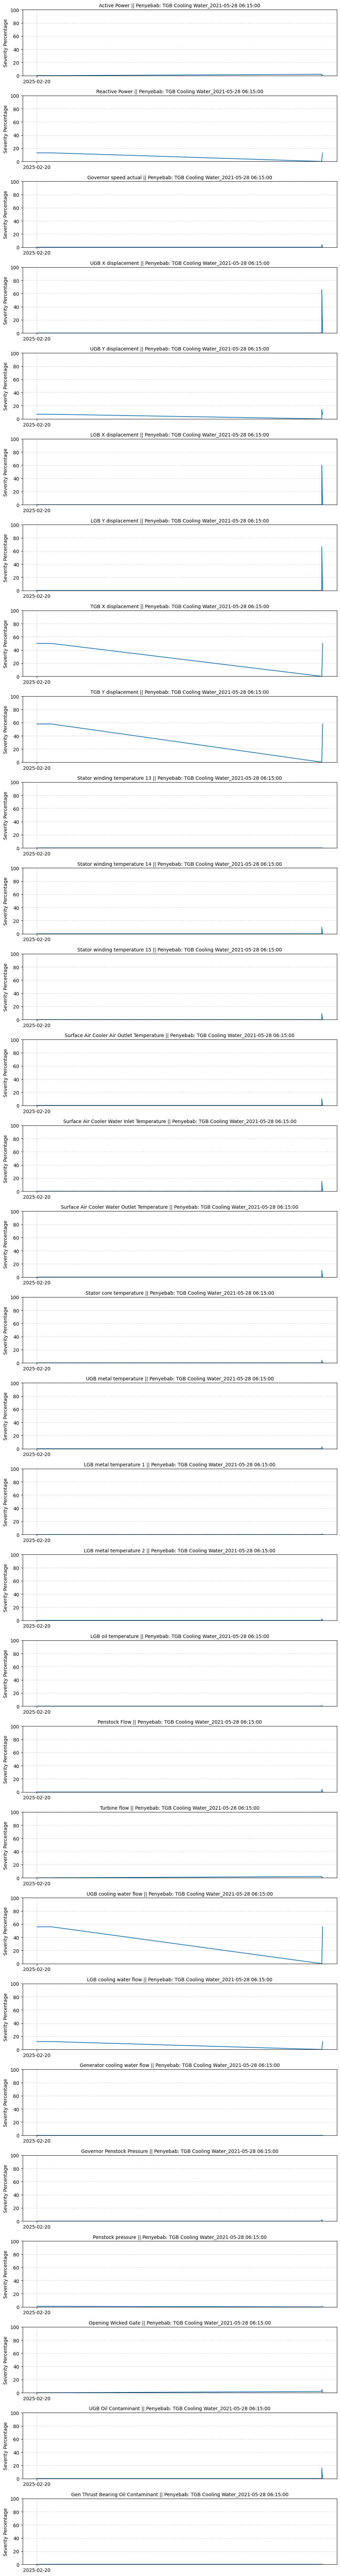

In [ ]:
fig, axes = plt.subplots(30, 1, figsize=(10, 75))
for i, ax in enumerate(axes):
    ax.plot(data_timestamp, data_feature[:, i])  # Plot data for each row
    ax.set_title(f'{feature_set[i]} || Penyebab: {df_anomaly_unplaned.values[failure_index_list, 4]}_{df_anomaly_unplaned.values[failure_index_list, 0]}', fontsize=10)  # Set title
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Severity Percentage")
    ax.set_xticks(data_timestamp[::7])  # Reduce number of ticks

plt.tight_layout()
plt.show()